In [1]:
%matplotlib inline

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
#sns.set() # matplot lib defaults
plt.rcParams['figure.figsize'] = (24, 6)
%config InlineBackend.figure_format='retina'

In [33]:
# find the notebook the saved figures came from
fig_prefix='../figures/jq-'

In [34]:
from IPython.display import FileLink
FileLink('./data_cleanup.ipynb')

/Users/jing/Documents/LambdaSchool/lambda_lab/notebooks/data_cleanup.ipynb

In [35]:
df = pd.read_sql_table('data', 'sqlite:///../data/mydb.db')  

In [36]:
df.head(3)

,id,market,product,country,date,retail,wholesale,currency,year,month,day,week
0,0,Bujumbura,Maize,Burundi,2011-10-04,NaN,548798.0,BIF,2011.0,10.0,4.0,40.0
1,1,Bujumbura,Maize,Burundi,2011-10-05,NaN,549000.0,BIF,2011.0,10.0,5.0,40.0
2,2,Bujumbura,Maize,Burundi,2011-10-06,NaN,498970.0,BIF,2011.0,10.0,6.0,40.0


In [37]:
# cutoff-date to avoid large data gap, this can be automated later
cutoff_date='2011-09-20'
Market = 'Lira'

date_selected = (df['date']>cutoff_date )
market_selected = (df['market']==Market)
product_selected = ( df['product']=='Maize')

condition = date_selected & market_selected & product_selected
df = df[condition]
df.head()

,id,market,product,country,date,retail,wholesale,currency,year,month,day,week
60460,60460,Lira,Maize,Uganda,2011-09-21,NaN,599585.0,UGX,2011.0,9.0,21.0,38.0
60461,60461,Lira,Maize,Uganda,2011-09-22,NaN,658600.0,UGX,2011.0,9.0,22.0,38.0
60462,60462,Lira,Maize,Uganda,2011-09-23,NaN,657473.0,UGX,2011.0,9.0,23.0,38.0
60463,60463,Lira,Maize,Uganda,2011-09-24,NaN,666448.0,UGX,2011.0,9.0,24.0,38.0
60464,60464,Lira,Maize,Uganda,2011-09-27,NaN,648178.0,UGX,2011.0,9.0,27.0,39.0


In [38]:
# remove duplicated row
rows_rm = df.duplicated('date', keep='last')

if np.sum(rows_rm):
    df = df[~rows_rm]
    
print(f'Length of data before removing duplicates: {len(rows_rm)}, after {len(df)}')

Length of data before removing duplicates: 2239, after 1794


In [9]:
retail = df[['date', 'retail']]
retail = retail.sort_values('date')
retail.set_index('date', inplace=True)
retail.tail(10)

,retail
date,
2020-03-03,1200001.0
2020-03-05,1200360.0
2020-03-06,1196448.0
2020-03-10,1198771.0
2020-03-12,1200456.0
2020-03-13,1200656.0
2020-03-17,1205755.0
2020-03-19,1213854.0
2020-03-25,1188807.0


In [10]:
wholesale = df[['date', 'wholesale']].sort_values('date')
wholesale.set_index('date', inplace=True)
wholesale.loc['2011-09-01':'2011-09-30']


,wholesale
date,
2011-09-21,599585.0
2011-09-22,658600.0
2011-09-23,657473.0
2011-09-24,666448.0
2011-09-27,648178.0
2011-09-30,695379.0


In [11]:
# construct complete time frame
date_range = pd.date_range(start=retail.index[0], end=retail.index[-1], freq='D')

time_df=pd.DataFrame([], index=date_range)
time_df.head()

""
2011-09-21
2011-09-22
2011-09-23
2011-09-24
2011-09-25


In [12]:
# construct data sample with complete time frame
yt = time_df.merge(wholesale, how='outer', left_index=True, right_index=True)
yt.tail(10)

,wholesale
2020-03-18,NaN
2020-03-19,930623.0
2020-03-20,NaN
2020-03-21,NaN
2020-03-22,NaN
2020-03-23,NaN
2020-03-24,NaN
2020-03-25,842071.0
2020-03-26,NaN
2020-03-27,868066.0


In [13]:
yw = yt.resample('W').last()

In [14]:
print(len(yt), len(yw))

3111 445


In [15]:
type(yt)

pandas.core.frame.DataFrame

visualization reveals different trends for different market, let's narrow down

In [16]:
def plot_one_time_series(df, color='k', alpha=1, label=Market):
    """time series of a df with datetime index"""
#     color = [0.1, 0.5, 0.5]
#     color_repeated =np.tile(np.array(color), (df.shape[0],1))
    #print(color_repeated)
    if isinstance(df, (pd.core.frame.DataFrame)):
       
        ax = fig.gca()
        ax.plot(df.index, df.values,#c = color_repeated, 
                color, label=label, alpha=alpha)
        ax.set_xlabel('Year', fontsize=20)
        ax.set_ylabel('Wholesale price by day', fontsize=20)
        ax.tick_params(axis="x", labelsize=20)
        ax.tick_params(axis="y", labelsize=20) 
        ax.legend()
        
    else:
        raise Exception('Wrong type! Plot funiction only take dataframe as input.')

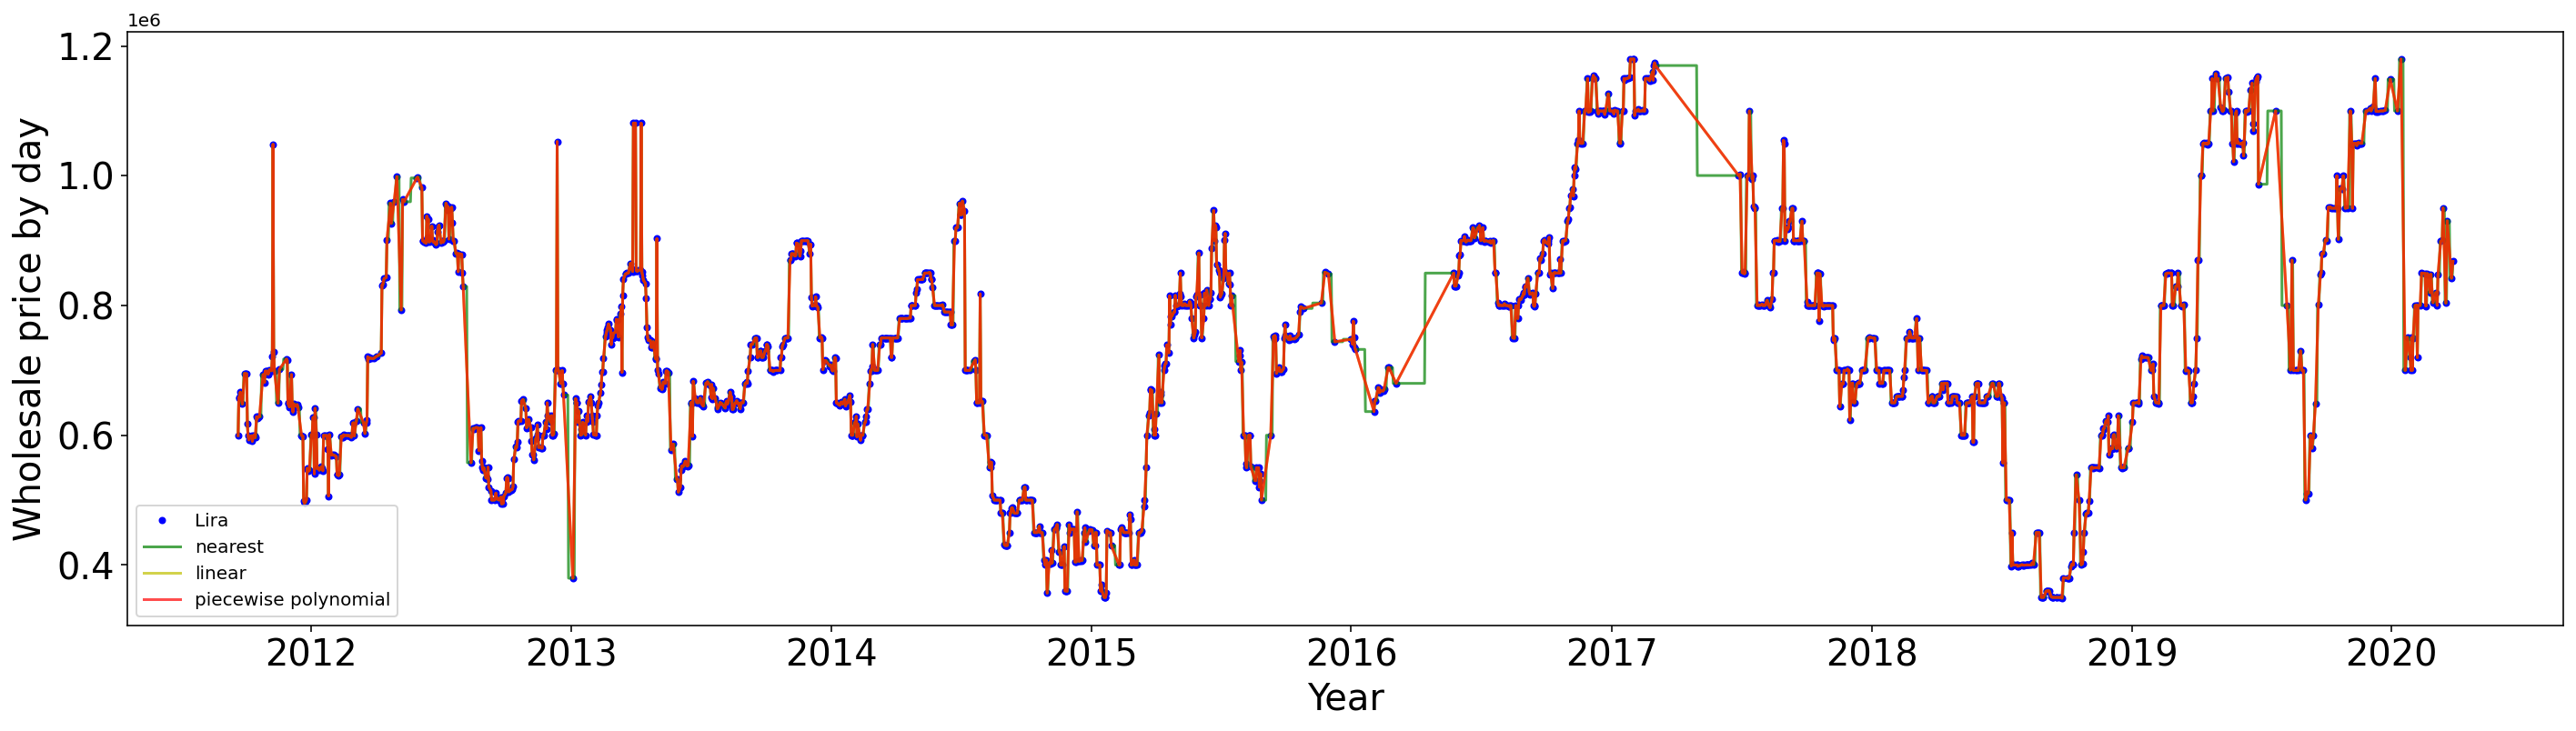

In [17]:
# replace the NaN with interpolated values and visualize for best interpolation method
# since the data is rather ragged, nerest method is picked

yt_n = yt.interpolate(method='nearest')
yt_l = yt.interpolate(method='linear')
yt_pp = yt.interpolate(method='piecewise_polynomial', order=2)

# visualize for best interpolation method
fig = plt.figure()
plot_one_time_series(yt,'b.', label='Lira')
plot_one_time_series(yt_n,'g', label='nearest', alpha=0.7)
plot_one_time_series(yt_l,'y', label='linear', alpha=0.7)
plot_one_time_series(yt_pp,'r', alpha=0.7, label='piecewise polynomial')

plt.show()

y_i = yt_n # y_i: interpolated y

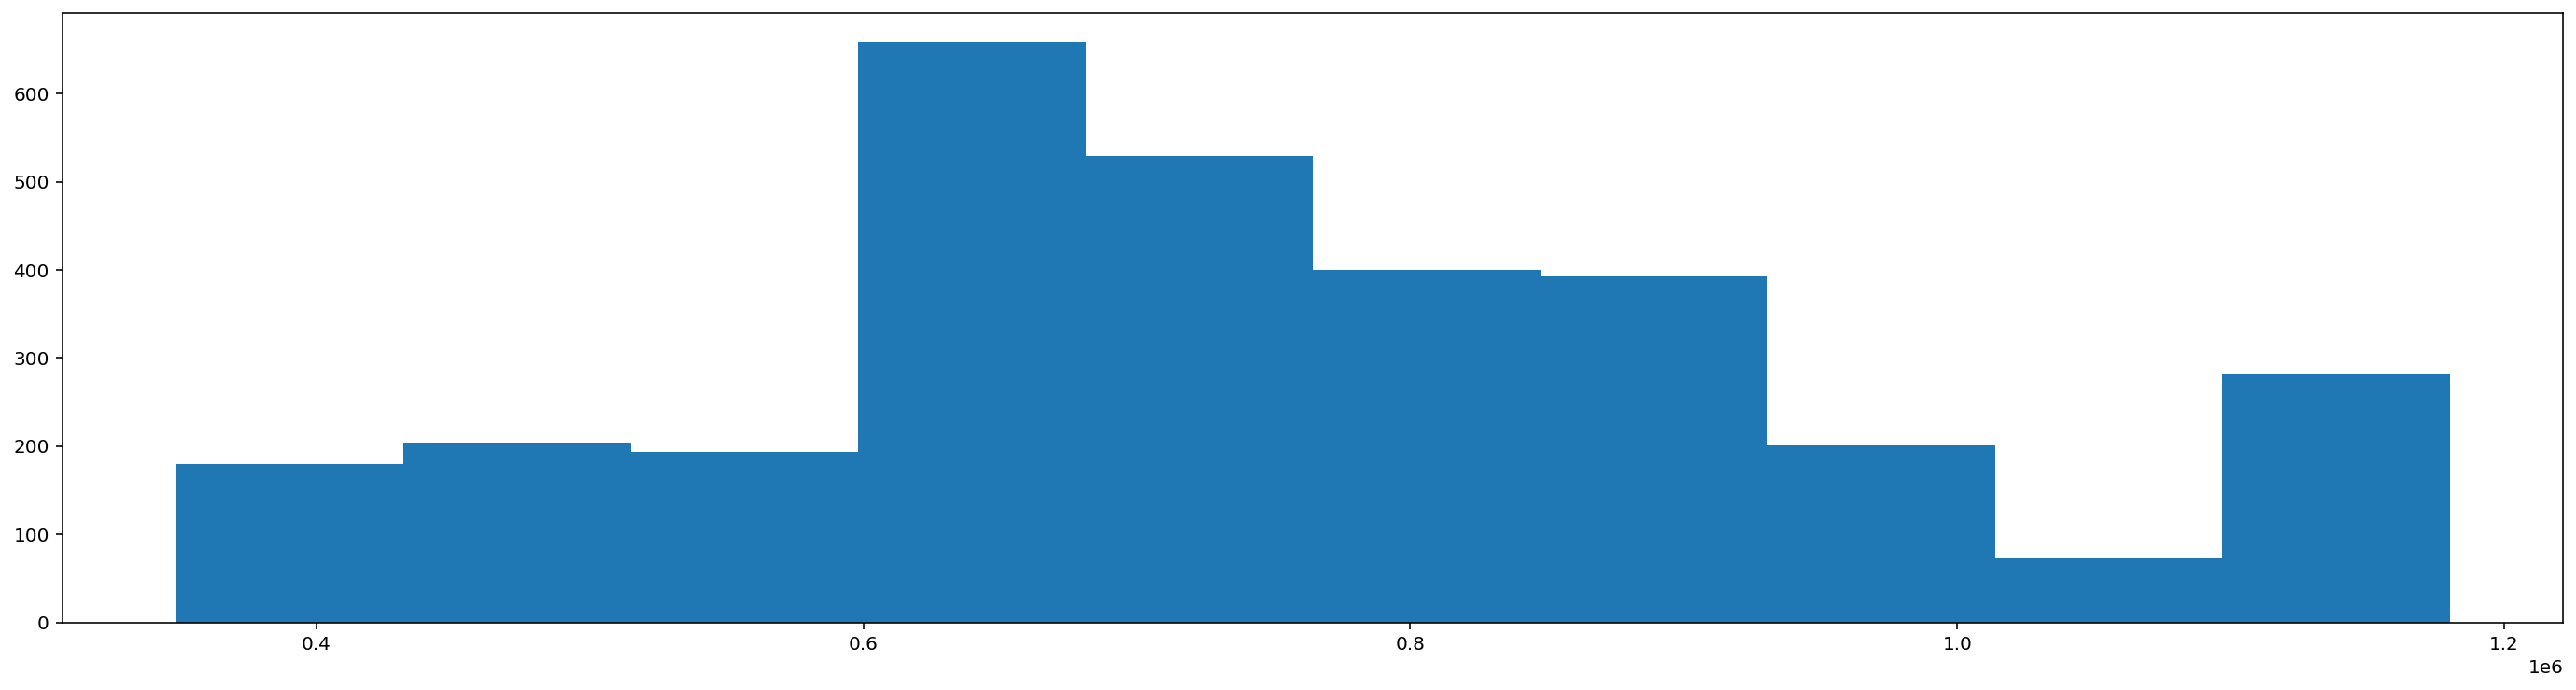

In [18]:
# check the distribution of the data
plt.hist(y_i['wholesale'])
plt.show()

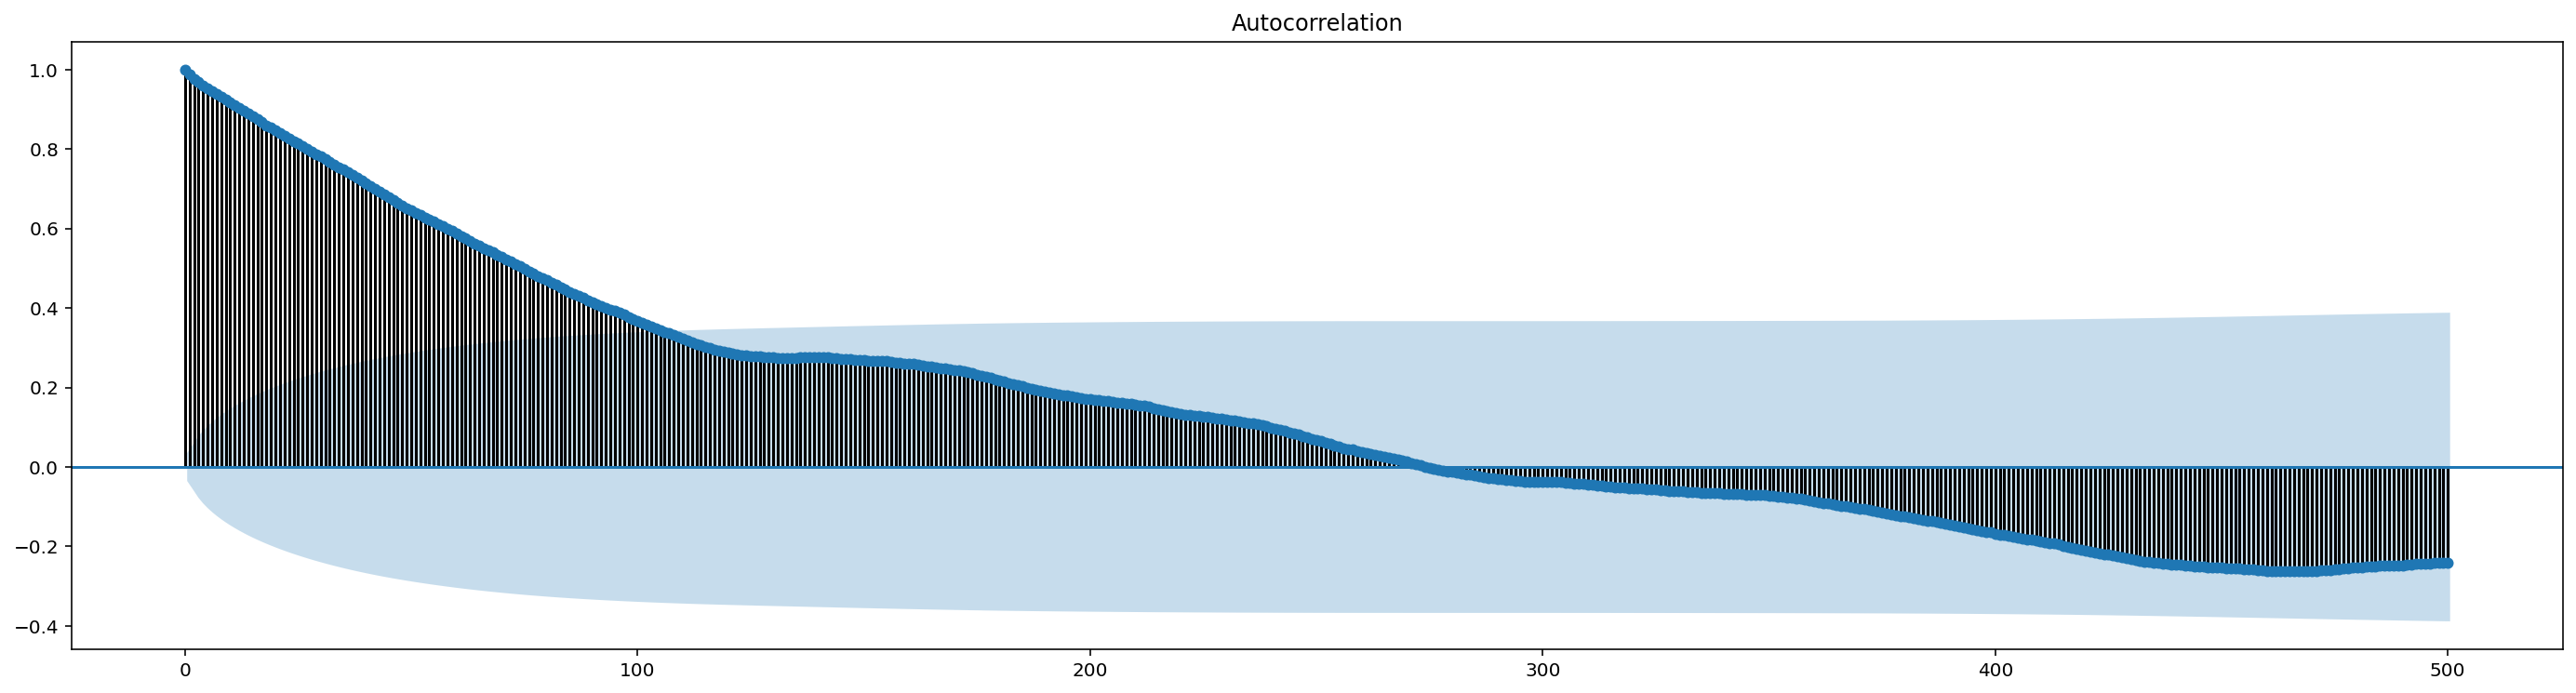

In [19]:
# ACF plot 
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y_i, lags=500)
plt.show()

In the above correlation plot the cone represents 95% confidence interval.
Notice that we have good positive correlation with the lags upto >700. We cannot use all of those correlations as it will create multi-collinearity problem. Next check on PACF plot to get only the most relevant lags!

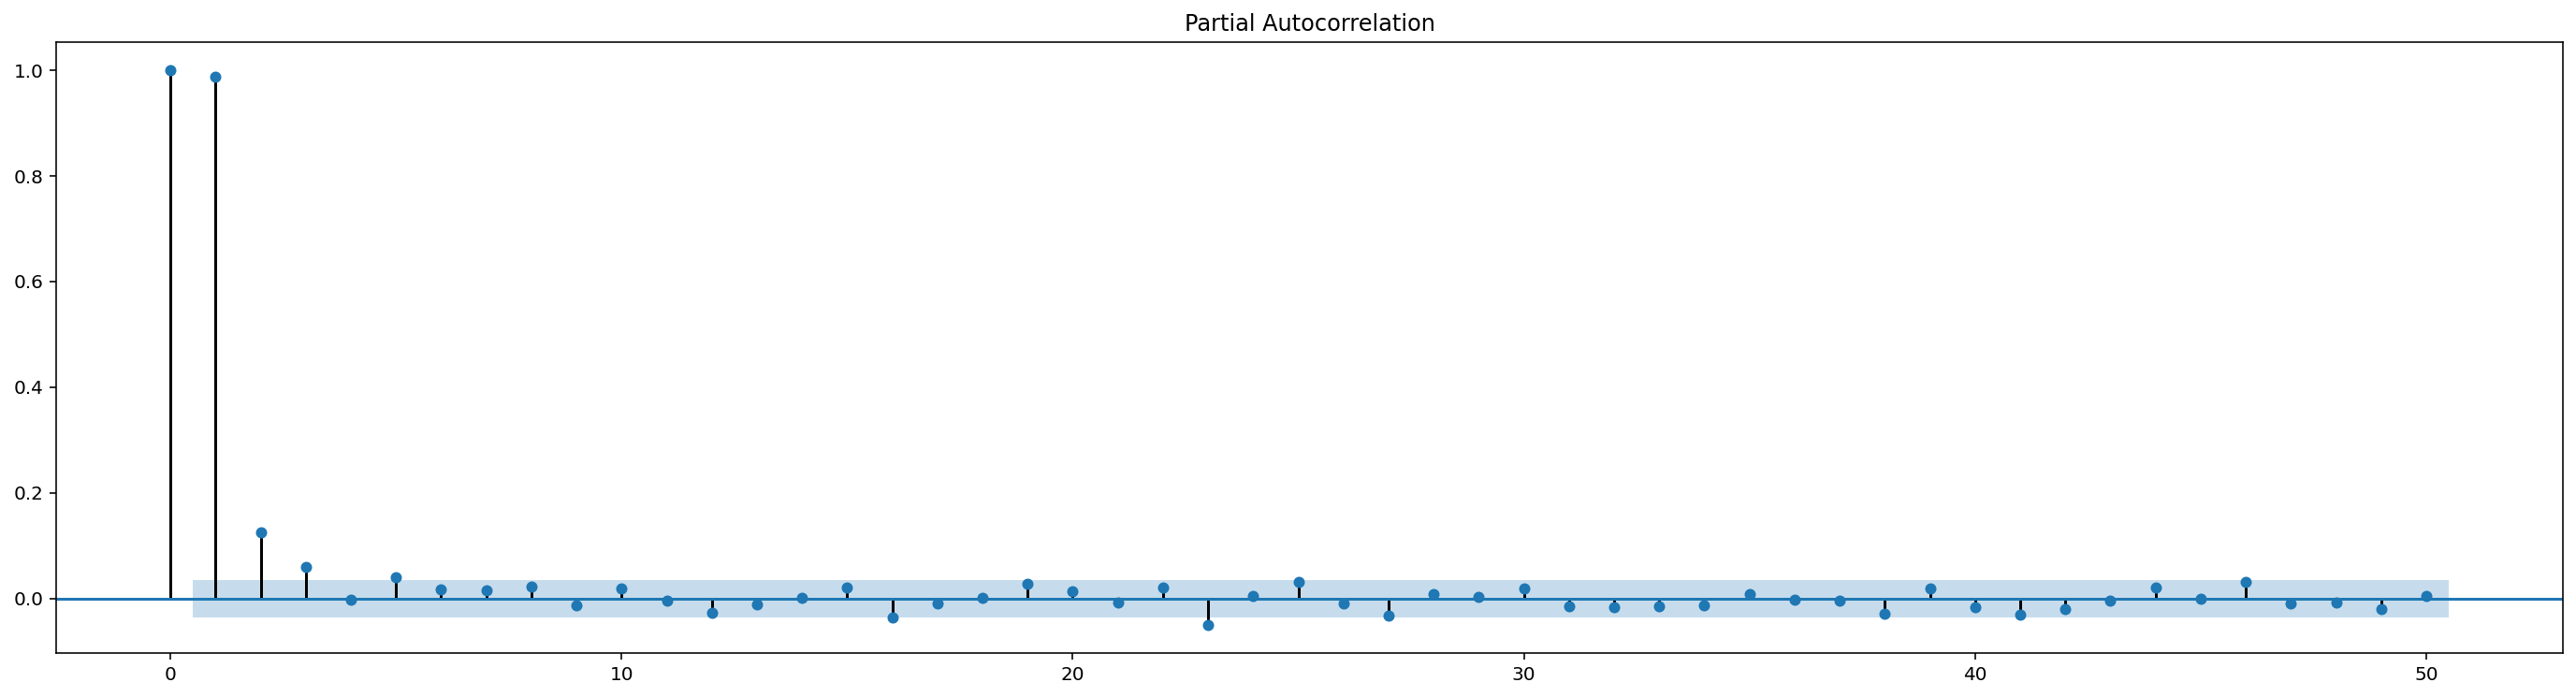

In [20]:
# PACF plot 
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(y_i, lags=50, method='ols')
plt.show()

PACF plots show that lags upto 4 have good correlation before the plot first cuts the upper confidence interval. So for the AR process, use lag 4. 

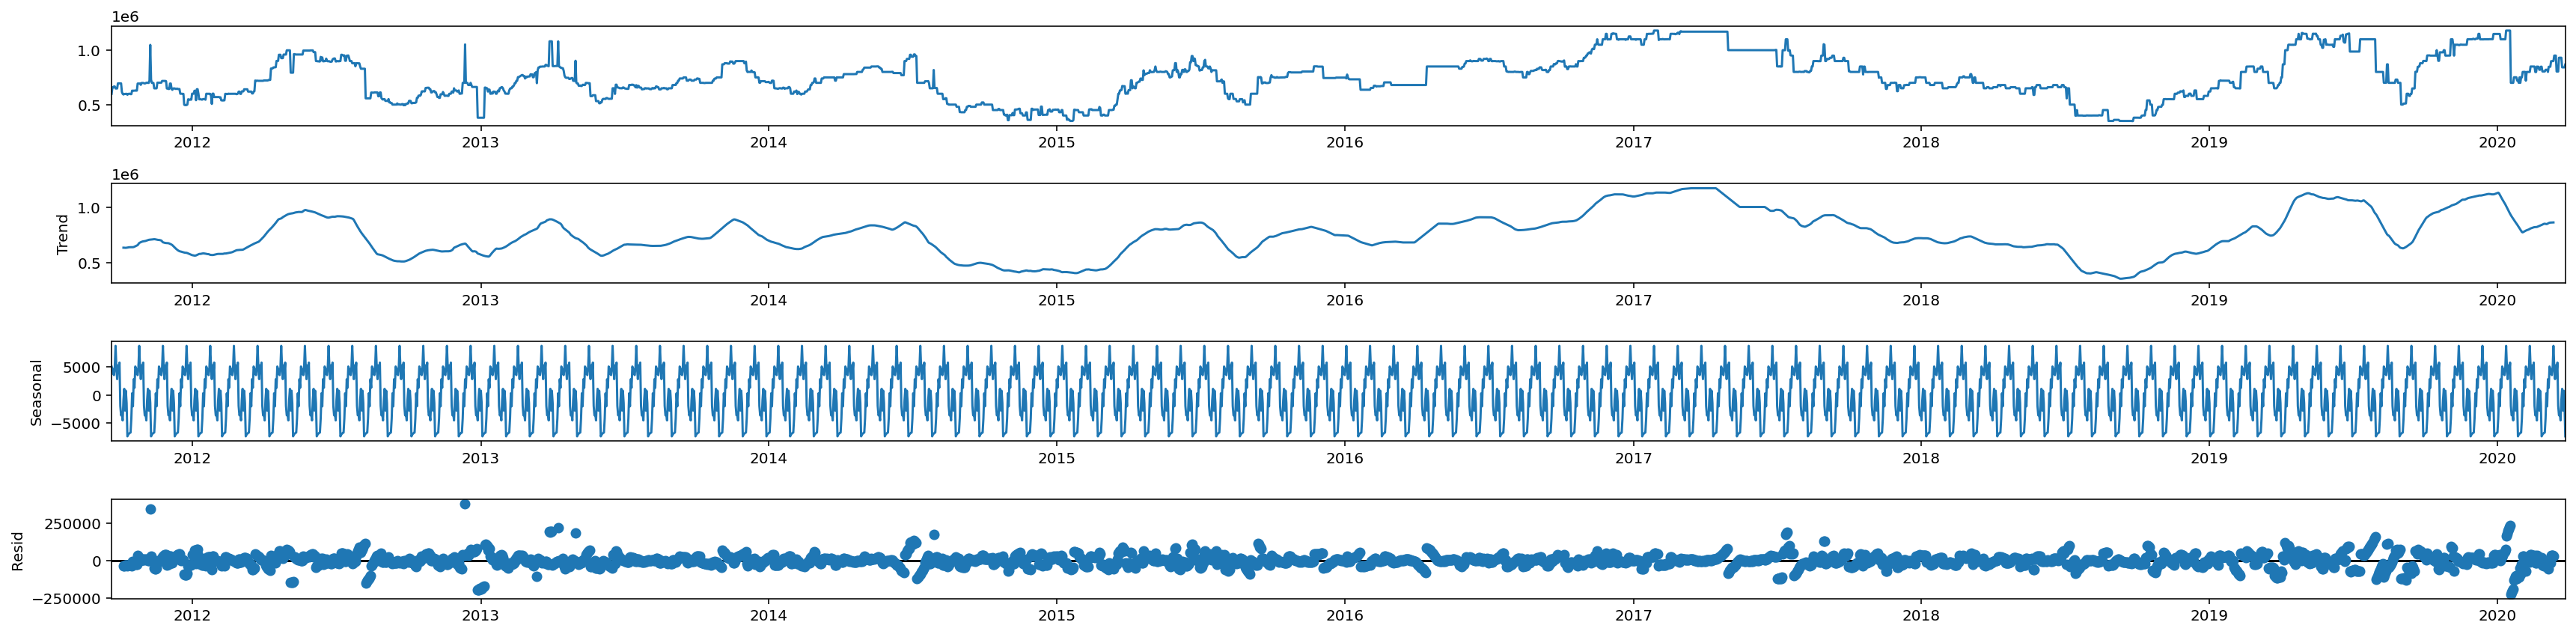

In [25]:
# first see if we can assume there is no trend and seasonal components:
from statsmodels.tsa.seasonal import seasonal_decompose
period = 30 
s = seasonal_decompose(y_i,
                       period=period,
                       model='additive')

s.plot()
plt.show()

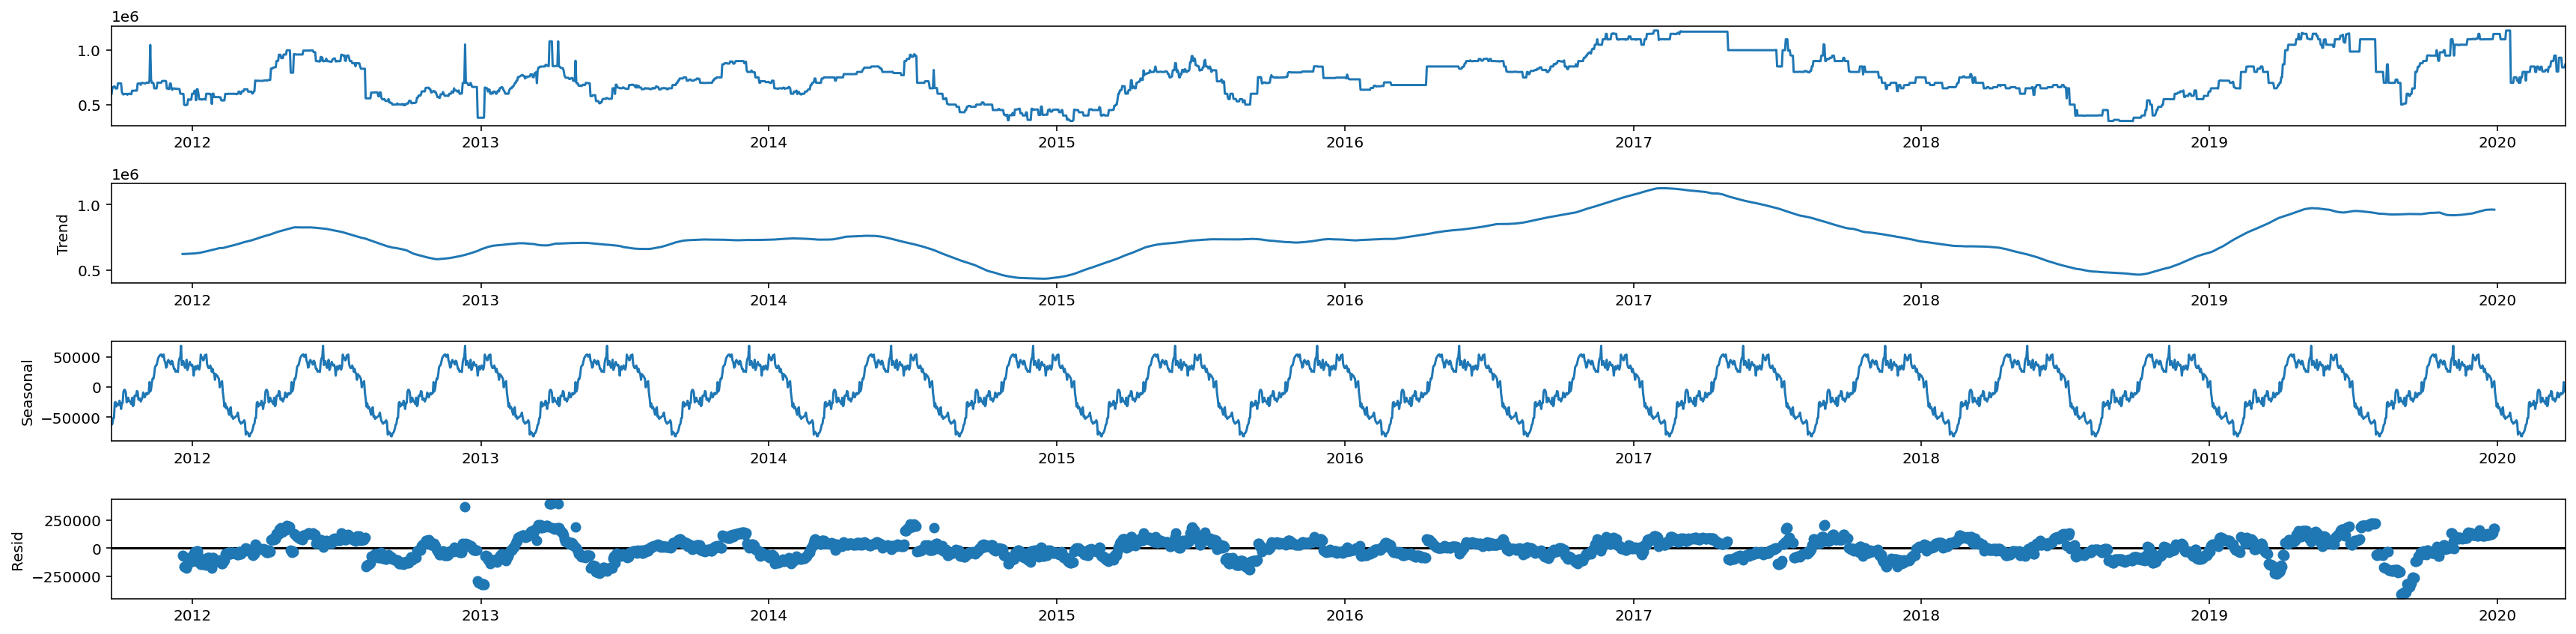

In [26]:
# first see if we can assume there is no trend and seasonal components:
from statsmodels.tsa.seasonal import seasonal_decompose
# see 6 month seasonal component 
period = 30*6 # how many data in 6 mo
s = seasonal_decompose(y_i,
                       period=period,
                       model='additive')

s.plot()
plt.show()

In [57]:
fig = plt.figure(figsize=(22, 8))

ax1=fig.add_subplot(411)
ax1.plot(yt,'.')
ax1.title.set_text('Interpolated daily price')

ax2=fig.add_subplot(412)
ax2.plot(s.trend)
ax2.title.set_text('trend')

ax1=fig.add_subplot(413)
ax1.plot(s.seasonal)
ax1.title.set_text('Seasonal component')

ax2=fig.add_subplot(414)
ax2.plot(s.resid,'.', markersize=5)
ax2.title.set_text('Residuals')

plt.show()

Note: my coworker used a Seasonal Autoregressive Integrated Moving-Average (SARIMA) to predict.
So I am trying a different approach.

!!! Thoughts: the trend is not really a trend. Maybe I should discard data before 2012 to get trend, seasonal component, and a NIID noise.

/Users/jing/.pyenv/versions/3.8.1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/jing/.pyenv/versions/3.8.1/lib/python3.8/site-packages/statsmodels/tsa/holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


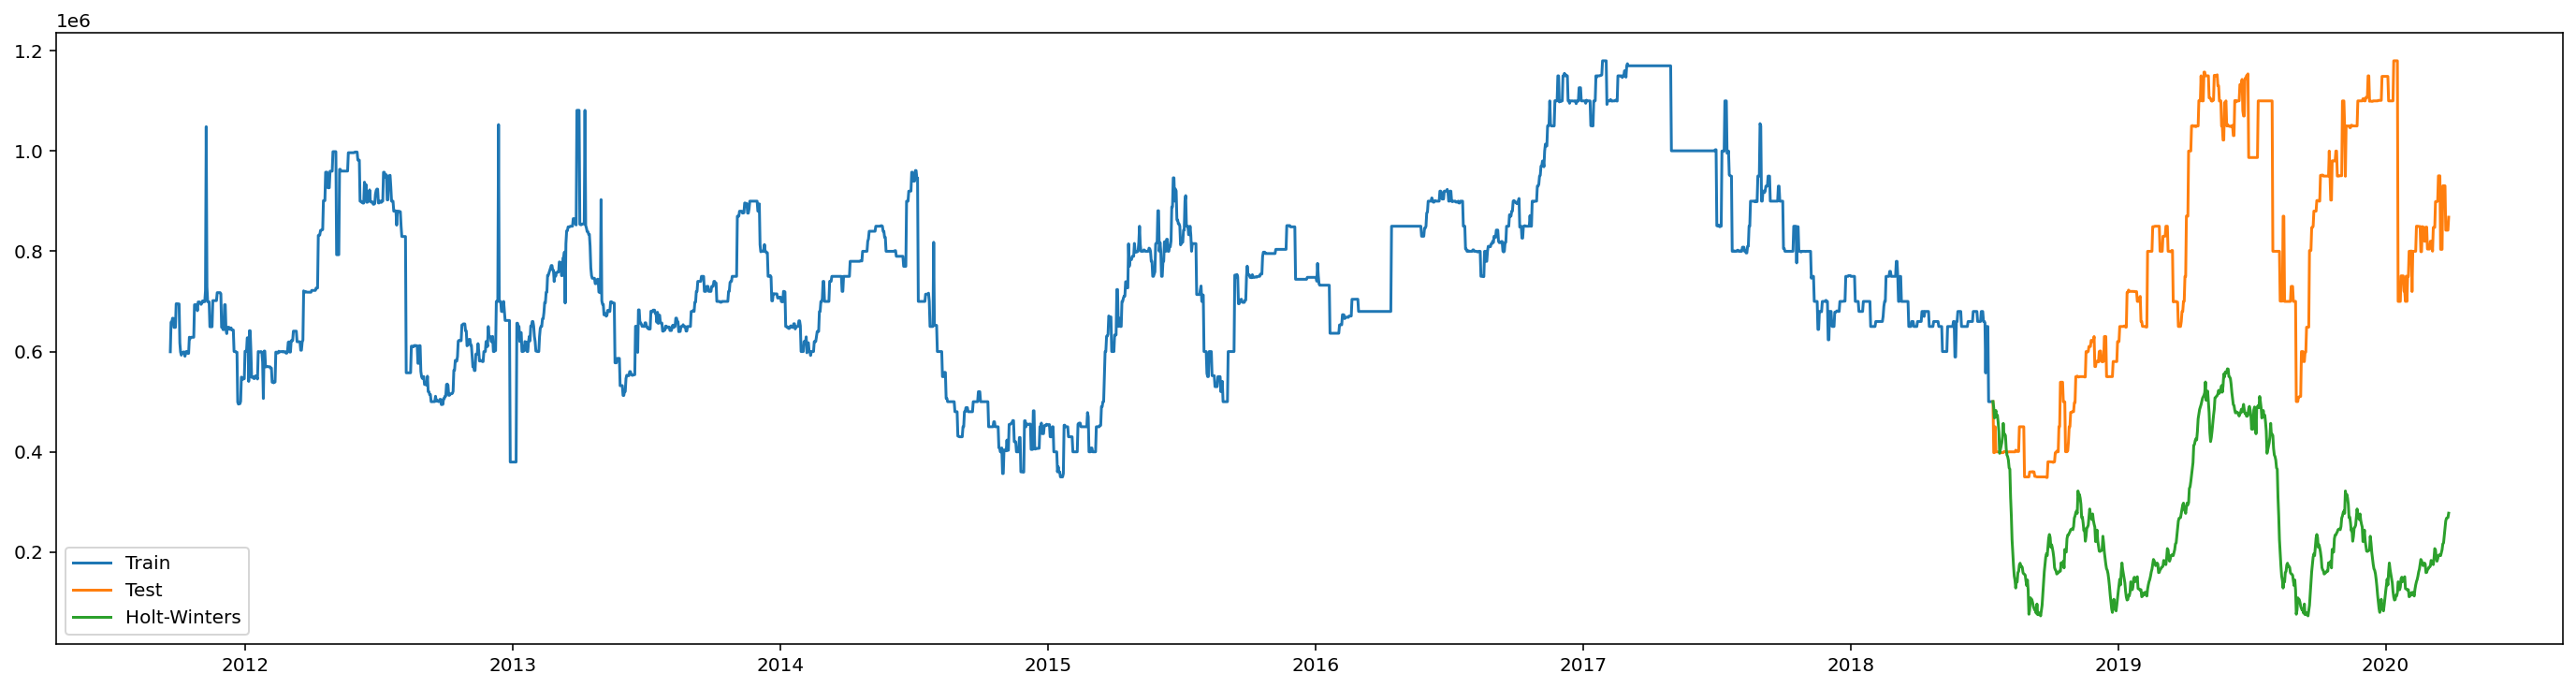

In [28]:
#  Predict using Holt Winter’s Exponential Smoothing (HWES), time series with trend and seasonal component
from statsmodels.tsa.holtwinters import ExponentialSmoothing

T = int(0.8*len(y_i))
train, test=y_i.iloc[:T,0], y_i.iloc[T:,0]

model = ExponentialSmoothing(train, 
                             trend='add', 
                             seasonal='add', 
                             seasonal_periods=365, 
                             damped=True)

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=False)
# optimize smoothing level, slope, seasonal, and damping slope
# Need to grid search other hyperparameters

pred = hw_model.predict(start=test.index[0], end=test.index[-1])

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')
## ??? model is sensitive to the start of prediction, will that be solved use cross validation?

In [68]:
# split data for cross validation
from sklearn.model_selection import TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=np.round(len(y_i)*0.9))
tscv

TimeSeriesSplit(max_train_size=2800.0, n_splits=5)

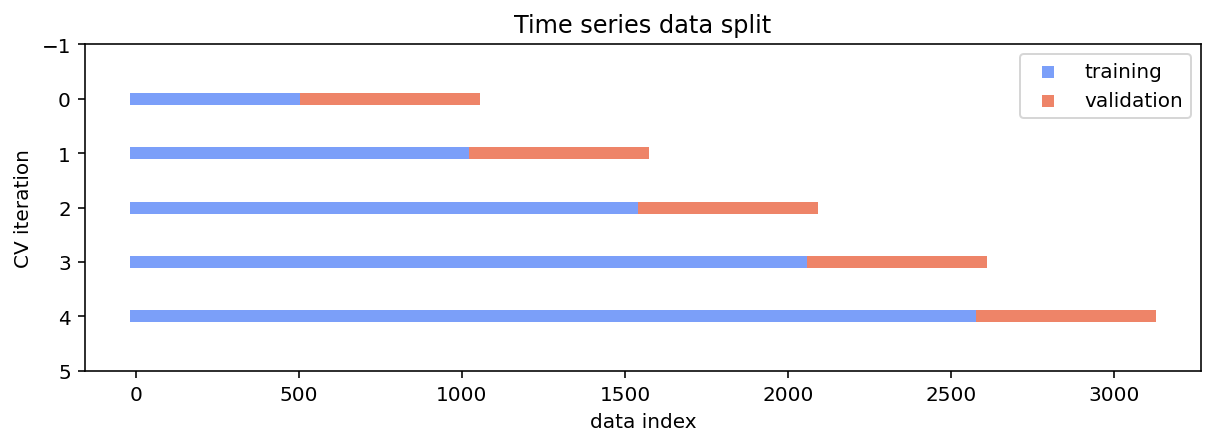

In [69]:
# visualize how the cross validation split is like for this time series
fig, ax = plt.subplots(figsize=(10, 3))
for ii, (train, test) in enumerate(tscv.split(y_i)):
    l1 =ax.scatter(train, [ii]*len(train), c=[plt.cm.coolwarm(.2)], marker='_', lw=6)
    l2 =ax.scatter(test, [ii]*len(test), c=[plt.cm.coolwarm(.8)], marker='_', lw=6)
    ax.set(ylim=[n_splits, -1], title = 'Time series data split',
          xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['training', 'validation'])


In [74]:
# grid search 
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# split into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [76]:
# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model
    history = np.array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

In [77]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

In [78]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

In [79]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores
 

In [80]:
# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

In [83]:
cfg_list =exp_smoothing_configs(seasonal=[0,6,12,365])

In [85]:
#if __name__ == '__main__':
# load dataset
series = y_i
data = series.values
# data split
n_test = 12
# model configs
cfg_list = exp_smoothing_configs(seasonal=[0,6,12])
# grid search
scores = grid_search(data[:,0], cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)
        

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
                  "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits 

In [70]:
# cv
i = 1
score=[]
for tr_index, val_index in tscv.split(y_i):
    y_tr, y_val = y_i[tr_index], y_i[val_index]
    rf = RandomForestRegressor(
                        max_features=int(mf),
                        n_estimators=int(ne),
                        max_depth=int(md),
                        min_samples_leaf=int(msl))
    rf.fit(y_tr)
    score.append(rf.score(y_val))

KeyError: "None of [Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,\n            ...\n            511, 512, 513, 514, 515, 516, 517, 518, 519, 520],\n           dtype='int64', length=521)] are in the [columns]"

In [ ]:
# First assume there is no trend nor seasonal components,
# and apply autorgressive integrated moving average (ARIMA) model
from statsmodels.tsa.arima_model import ARIMA
# first trial: lag 1 autogressive term, 1 degree of differencing, first-order ma term, 
model = ARIMA(y_i, order=(4, 1, 1))
model_fit = model.fit()
yt_pred = model_fit.predict(len(y_i), len(y_i))


In [ ]:
np.prod(yt_ma.isnull()) # why the moving avg return all nulls?

In [ ]:
plot_one_time_series(yt_ma)